In [28]:
import pandas as pd
import numpy as np

# --- 1. SETUP: Define file paths ---
path = r'C:\Users\Admin\Desktop\Guvi Live Session\Guvi Projects'
excel_file_name = r'\OLA_DataSet.xlsx'
full_path = path + excel_file_name

# --- 2. LOGIC: Read each sheet and extract data blocks ---
sheet_names = ['Sheet1', 'Sheet2', 'July']
final_clean_dfs = []

print("Starting the data extraction process...")

try:
    for sheet in sheet_names:
        df_raw = pd.read_excel(full_path, sheet_name=sheet, header=None)
        
        clean_data_blocks = {}
        for col_index in df_raw.columns:
            series = df_raw[col_index].dropna().tolist()
            if len(series) > 1:
                header = series[0]
                data = series[1:]
                if isinstance(header, str):
                    header = header.strip()
                    clean_data_blocks[header] = data
        
        df_sheet_clean = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in clean_data_blocks.items()]))
        final_clean_dfs.append(df_sheet_clean)

    # --- 3. COMBINE: Stack the clean DataFrames from all sheets ---
    ola_df = pd.concat(final_clean_dfs, ignore_index=True)
    print("\n✅ Data has been correctly assembled!")
    
    # --- 4. THE CRITICAL CLEANING STEP ---
    print("Removing junk rows and cleaning up...")
    
    # Keep only the rows where the 'Date' column can be a real date
    # 'to_datetime' with 'errors=coerce' will turn any non-date text into 'NaT' (Not a Time)
    ola_df['Date'] = pd.to_datetime(ola_df['Date'], errors='coerce')
    ola_df.dropna(subset=['Date'], inplace=True) # Drop rows where 'Date' is NaT

    # --- 5. CLEAN & CONVERT DATA TYPES ---
    # Now that junk rows are gone, we can safely convert the other columns
    
    # Create the final booking_timestamp
    # The 'Time' column might have non-time values, so we handle errors
    ola_df['Time'] = ola_df['Time'].astype(str)
    ola_df['booking_timestamp'] = pd.to_datetime(ola_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + ola_df['Time'], errors='coerce')
    
    # Drop the original Date and Time columns
    ola_df = ola_df.drop(columns=['Date', 'Time'])

    # Convert numeric columns
    numeric_cols = ['V_TAT', 'C_TAT', 'Booking_Value', 'Ride_Distance', 'Driver_Ratings', 'Customer_Rating']
    for col in numeric_cols:
        if col in ola_df.columns:
            ola_df[col] = pd.to_numeric(ola_df[col], errors='coerce')

    # Drop useless columns (identified from previous outputs)
    cols_to_drop = [col for col in ola_df.columns if 'Unnamed' in str(col) or 'https' in str(col) or 'Sedan' in str(col)]
    ola_df = ola_df.drop(columns=cols_to_drop)

    print("Data types converted and final cleanup is done!")

except Exception as e:
    print(f"\n❌ An error occurred: {e}")

# --- 6. FINAL CHECK: Display the results ---
print("\n--- Here is our FINAL, CLEAN dataset! ---")
print(ola_df.head())
print(f"\nShape of the final table: {ola_df.shape[0]} rows and {ola_df.shape[1]} columns.")
print("\n--- Final Data Info ---")
ola_df.info()

Starting the data extraction process...

✅ Data has been correctly assembled!
Removing junk rows and cleaning up...


C:\Users\Admin\AppData\Local\Temp\ipykernel_14816\3363043281.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ola_df['Date'] = pd.to_datetime(ola_df['Date'], errors='coerce')


Data types converted and final cleanup is done!

--- Here is our FINAL, CLEAN dataset! ---
   Vehicle_Type  Avg Distance        Booking_Status     Booking_ID  \
24  Prime Sedan           NaN    Canceled by Driver  CNR7153255142   
25         Bike           NaN               Success  CNR2940424040   
26    Prime SUV           NaN               Success  CNR2982357879   
27        eBike           NaN  Canceled by Customer  CNR2395710036   
28         Mini           NaN               Success  CNR1797421769   

   Customer_ID Pickup_Location Drop_Location  V_TAT  C_TAT  \
24   CID713523     Tumkur Road      RT Nagar  203.0   30.0   
25   CID225428     Magadi Road       Varthur  238.0  130.0   
26   CID270156   Sahakar Nagar       Varthur  252.0   80.0   
27   CID581320      HSR Layout   Vijayanagar  231.0   90.0   
28   CID939555     Rajajinagar   Chamarajpet  133.0   40.0   

                      Canceled_Rides_by_Customer  \
24  Driver is not moving towards pickup location   
25         

In [34]:
print("--- Starting Final Data Polishing ---")

# Let's make a copy to ensure we don't accidentally mess up our main DataFrame
df_final = ola_df.copy()

# 1. Rename misleading columns for clarity
df_final.rename(columns={
    'Canceled_Rides_by_Customer': 'Customer_Cancel_Reason',
    'Canceled_Rides_by_Driver': 'Driver_Cancel_Reason'
}, inplace=True)

print("Columns renamed successfully.")

# 2. Drop the completely empty 'Avg Distance' column
if 'Avg Distance' in df_final.columns:
    df_final.drop(columns=['Avg Distance'], inplace=True)
    print("'Avg Distance' column dropped.")

# 3. Create the 'is_cancelled' derived feature
# We define a list of all statuses that mean the ride failed
cancellation_statuses = ['Canceled by Driver', 'Canceled by Customer', 'Driver Not Found']

# If the status is in our list, 'is_cancelled' will be 1, otherwise 0
df_final['is_cancelled'] = df_final['Booking_Status'].apply(lambda x: 1 if x in cancellation_statuses else 0)

print("Derived feature 'is_cancelled' created.")


# --- Let's check our work ---
print("\n--- Polished DataFrame Info ---")
print(df_final.info())

print("\n--- Example of the new 'is_cancelled' column ---")
print(df_final[['Booking_Status', 'is_cancelled']].head())

--- Starting Final Data Polishing ---
Columns renamed successfully.
'Avg Distance' column dropped.
Derived feature 'is_cancelled' created.

--- Polished DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 103024 entries, 24 to 103047
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Vehicle_Type             103024 non-null  object        
 1   Booking_Status           103024 non-null  object        
 2   Booking_ID               103024 non-null  object        
 3   Customer_ID              103024 non-null  object        
 4   Pickup_Location          103024 non-null  object        
 5   Drop_Location            103024 non-null  object        
 6   V_TAT                    63967 non-null   float64       
 7   C_TAT                    63967 non-null   float64       
 8   Customer_Cancel_Reason   10499 non-null   object        
 9   Driver_Cancel_Reason     18434 non

--- Analysis of Vehicle Types ---
Number of bookings for each vehicle type:
Vehicle_Type
Prime Sedan    14877
eBike          14816
Auto           14755
Prime Plus     14707
Bike           14662
Prime SUV      14655
Mini           14552
Name: count, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_14816\2826481603.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vehicle_counts.index, y=vehicle_counts.values, palette='viridis')


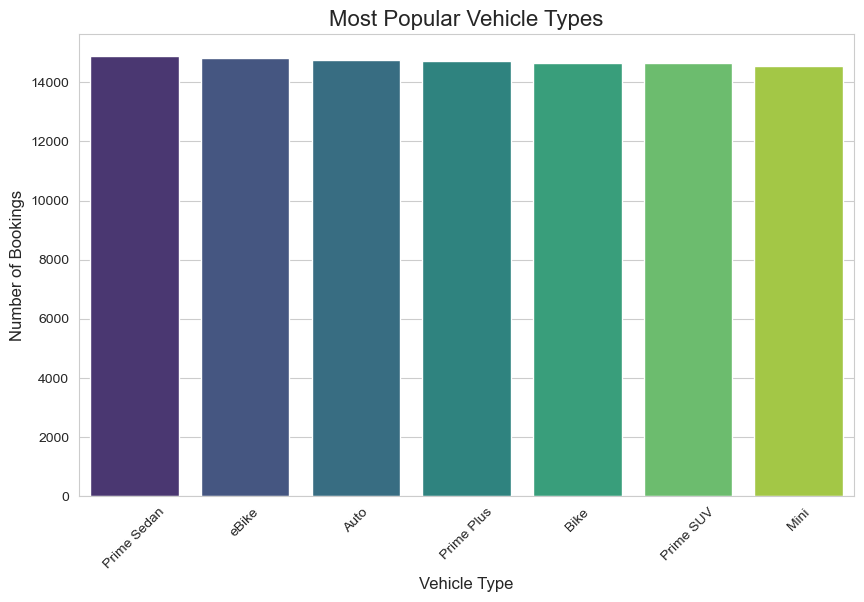

In [29]:
# Import the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Let's set a nice style for our charts
sns.set_style('whitegrid')

print("--- Analysis of Vehicle Types ---")

# 1. Count how many times each vehicle type appears
vehicle_counts = ola_df['Vehicle_Type'].value_counts()

print("Number of bookings for each vehicle type:")
print(vehicle_counts)


# 2. Create a bar chart to visualize the counts
plt.figure(figsize=(10, 6)) # Create a figure to draw on (width=10, height=6)
sns.barplot(x=vehicle_counts.index, y=vehicle_counts.values, palette='viridis')

# Add titles and labels for clarity
plt.title('Most Popular Vehicle Types', fontsize=16)
plt.xlabel('Vehicle Type', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45) # Rotate the x-axis labels to prevent them from overlapping

# Display the plot
plt.show()

--- Analysis of Booking Status ---
Number of rides for each booking status:
Booking_Status
Success                 63967
Canceled by Driver      18434
Canceled by Customer    10499
Driver Not Found        10124
Name: count, dtype: int64


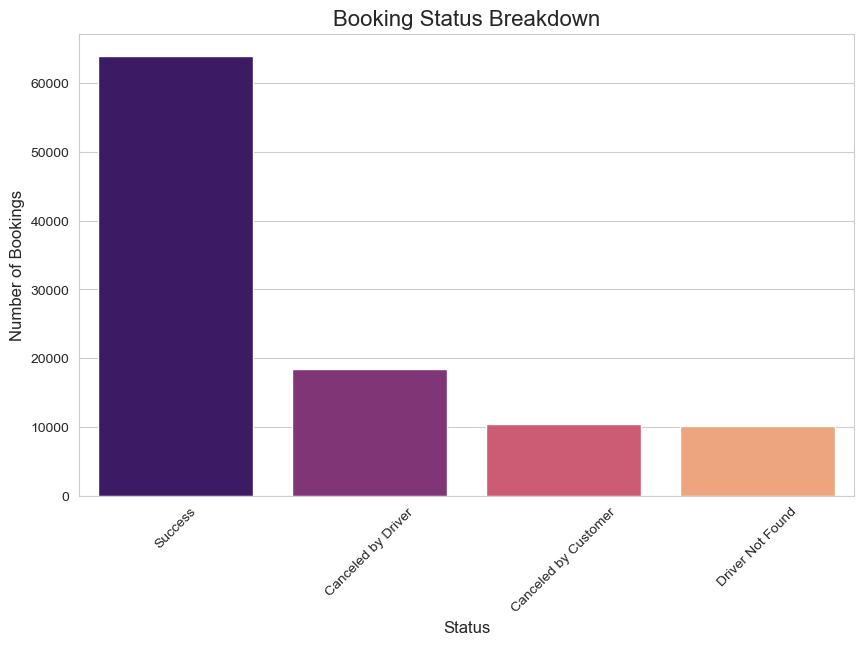

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for our charts
sns.set_style('whitegrid')

print("--- Analysis of Booking Status ---")

# 1. Count the occurrences of each booking status
status_counts = ola_df['Booking_Status'].value_counts()

print("Number of rides for each booking status:")
print(status_counts)


# 2. Create a bar chart to visualize the status counts
plt.figure(figsize=(10, 6))

# This time, we use the newer seaborn syntax to avoid the warning
sns.barplot(x=status_counts.index, y=status_counts.values, hue=status_counts.index, palette='magma', legend=False)

# Add titles and labels
plt.title('Booking Status Breakdown', fontsize=16)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=45)

# Display the plot
plt.show()

--- Analysis of Cancellation Hotspots ---
Total number of canceled rides being analyzed: 28933

Top 10 Pickup Locations for Cancellations:
Pickup_Location
Vijayanagar         643
Tumkur Road         640
Whitefield          625
Banashankari        625
Langford Town       622
RT Nagar            613
Kengeri             609
Hosur Road          607
Indiranagar         604
Ramamurthy Nagar    602
Name: count, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_14816\1562106104.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_cancellation_locations.values, y=top_10_cancellation_locations.index, palette='Reds_r')


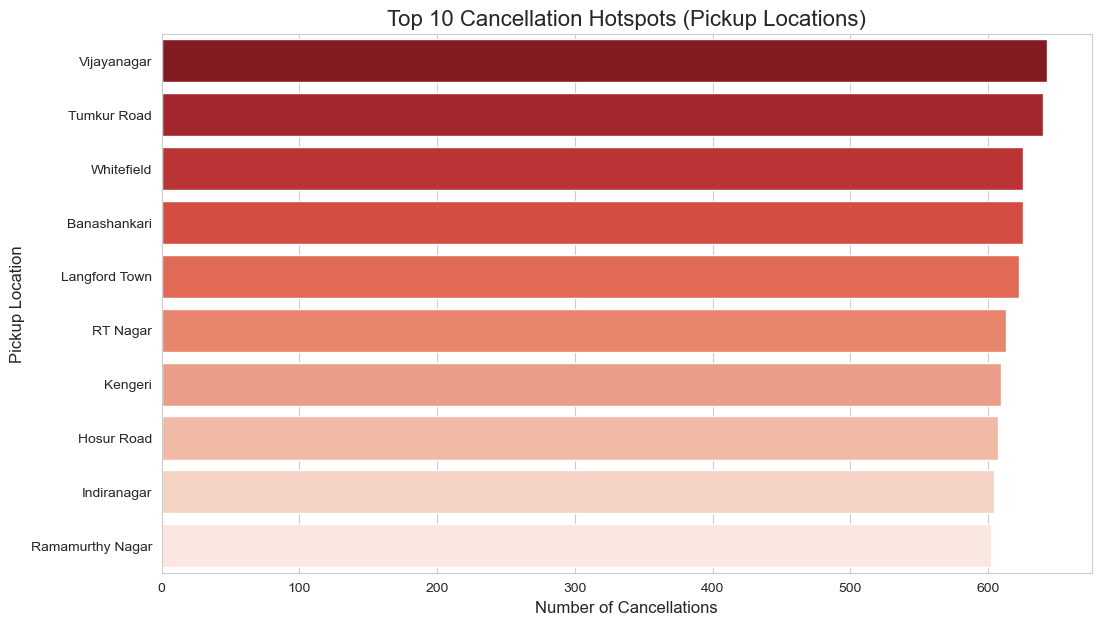

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

print("--- Analysis of Cancellation Hotspots ---")

# 1. Filter the DataFrame to only include canceled rides.
# We select rows where 'Booking_Status' is either 'Canceled by Driver' or 'Canceled by Customer'.
canceled_df = ola_df[
    (ola_df['Booking_Status'] == 'Canceled by Driver') |
    (ola_df['Booking_Status'] == 'Canceled by Customer')
]

print(f"Total number of canceled rides being analyzed: {len(canceled_df)}")

# 2. Count the pickup locations for these canceled rides and get the top 10.
top_10_cancellation_locations = canceled_df['Pickup_Location'].value_counts().nlargest(10)

print("\nTop 10 Pickup Locations for Cancellations:")
print(top_10_cancellation_locations)


# 3. Create a bar chart for the top 10 locations.
plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_cancellation_locations.values, y=top_10_cancellation_locations.index, palette='Reds_r')

plt.title('Top 10 Cancellation Hotspots (Pickup Locations)', fontsize=16)
plt.xlabel('Number of Cancellations', fontsize=12)
plt.ylabel('Pickup Location', fontsize=12)

plt.show()

--- Analysis of Peak Booking Times ---

Number of bookings per day of the week:
booking_day_of_week
Monday       16729
Tuesday      16926
Wednesday    16434
Thursday     13236
Friday       13345
Saturday     13341
Sunday       13013
Name: count, dtype: int64


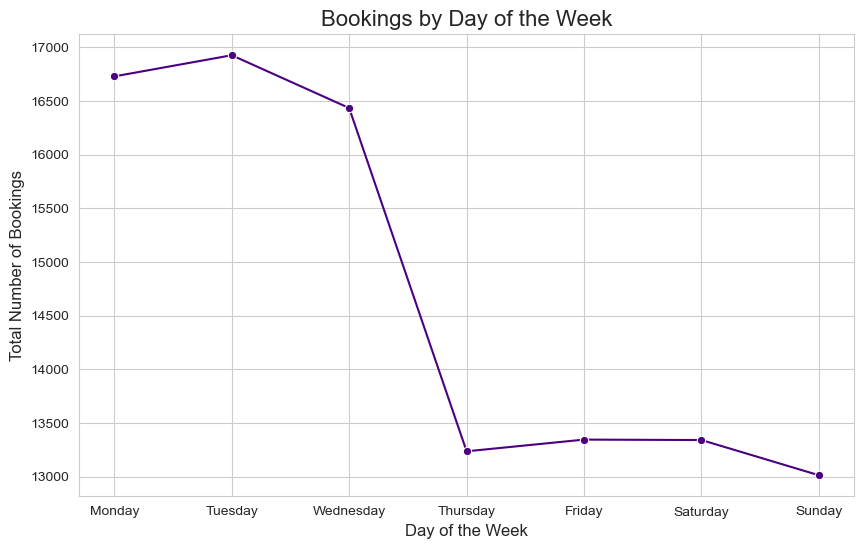


Number of bookings per hour of the day:


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

print("--- Analysis of Peak Booking Times ---")

# 1. Extract the day of the week and hour from the timestamp
# The .dt accessor lets us get properties of datetime objects
ola_df['booking_day_of_week'] = ola_df['booking_timestamp'].dt.day_name()
ola_df['booking_hour'] = ola_df['booking_timestamp'].dt.hour

# --- Chart 1: Bookings by Day of the Week ---

# Order the days correctly
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts = ola_df['booking_day_of_week'].value_counts().reindex(day_order)

print("\nNumber of bookings per day of the week:")
print(day_counts)

plt.figure(figsize=(10, 6))
sns.lineplot(x=day_counts.index, y=day_counts.values, marker='o', color='indigo')
plt.title('Bookings by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Number of Bookings', fontsize=12)
plt.show()


# --- Chart 2: Bookings by Hour of the Day ---

hour_counts = ola_df['booking_hour'].value_counts().sort_index()

print("\nNumber of bookings per hour of the day:")

In [36]:
import pandas as pd
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus # Import the necessary function

# --- Database Connection Details ---
db_user = 'root'
# Your original password
db_password_raw = 'Akshay@200' 
# Safely encode the password for the URL connection string
db_password = quote_plus(db_password_raw) 
db_host = '127.0.0.1'
db_name = 'ola_project' 

# --- 1. Connect to the MySQL Server ---
try:
    server_engine = create_engine(f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}")
    print("Connection to MySQL server successful.")
except Exception as e:
    print(f"Error connecting to server: {e}")

# --- 2. Create the Database if it Doesn't Exist ---
try:
    with server_engine.connect() as connection:
        connection.execute(text(f"CREATE DATABASE IF NOT EXISTS {db_name}"))
    print(f"Database '{db_name}' created or already exists.")
except Exception as e:
    print(f"Error creating database: {e}")

# --- 3. Connect to the Specific Database and Write the DataFrame ---
try:
    db_engine = create_engine(f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}")
    
    # Write the DataFrame to a table named 'ride_details'
    df_final.to_sql('ride_details', con=db_engine, if_exists='replace', index=False)
    
    print("\n✅ Success! Your DataFrame has been imported into MySQL as the 'ride_details' table.")

except Exception as e:
    print(f"\nError importing data to MySQL: {e}")

Connection to MySQL server successful.
Database 'ola_project' created or already exists.

✅ Success! Your DataFrame has been imported into MySQL as the 'ride_details' table.
